<a href="https://colab.research.google.com/github/vijay5158/Covid-19-Exploratory-Data-Analysis-and-Predictions-/blob/master/Covid_EDA_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install squarify
!pip install plotly_express

In [ ]:
 import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
import squarify
import plotly.offline as py
import plotly_express as px
 
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
 
from IPython.display import Image
warnings.filterwarnings('ignore')
%matplotlib inline
 
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
import pandas as pd
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
age_file = drive.CreateFile({'id': '1_z8RDqGQHjIVFAjquheQxSnypRzZufiR'})
age_file.GetContentFile('AgeGroupDetails.csv')
age_details = pd.read_csv('AgeGroupDetails.csv')
 
india_covid_file = drive.CreateFile({'id': '1_hPtODBMS28vM96OfSze6IJDVl_vRllG'})
india_covid_file.GetContentFile('covid_19_india.csv')
india_covid_19 = pd.read_csv('covid_19_india.csv')
 
hospital_beds_file = drive.CreateFile({'id': '1_p6F8SXAYK2GRf5qnZfpFqUHHFxR7hrh'})
hospital_beds_file.GetContentFile('HospitalBedsIndia.csv')
hospital_beds = pd.read_csv('HospitalBedsIndia.csv')
 
individual_details_file = drive.CreateFile({'id': '1a6jHG285L4tkd7ycz9dzJKGyWkxsyf3Y'})
individual_details_file.GetContentFile('IndividualDetails.csv')
individual_details = pd.read_csv('IndividualDetails.csv')
 
ICMR_labs_file = drive.CreateFile({'id': '1_k7-lEQEht0VXQiOVV8Y0dWN3MzXRO7t'})
ICMR_labs_file.GetContentFile('ICMRTestingLabs.csv')
ICMR_labs = pd.read_csv('ICMRTestingLabs.csv')
 
state_testing_file = drive.CreateFile({'id': '1_jsJcYCqO5l0DIE3DhkEXRNf08jZX-LK'})
state_testing_file.GetContentFile('StatewiseTestingDetails.csv')
state_testing = pd.read_csv('StatewiseTestingDetails.csv')
 
population_file = drive.CreateFile({'id': '1_fYUeKCjUolaCqk5z-wrc4eClB0JFKcX'})
population_file.GetContentFile('population_india_census2011.csv')
population = pd.read_csv('population_india_census2011.csv')
 
world_population_file = drive.CreateFile({'id': '1_e0LTpi6INm2AAPpgPvJEp8TxZ0obpCy'})
world_population_file.GetContentFile('population_by_country_2020.csv')
world_population = pd.read_csv('population_by_country_2020.csv')
 
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/04-04-2020.csv')
 
india_covid_19['Date'] = pd.to_datetime(india_covid_19['Date'],dayfirst = True)
state_testing['Date'] = pd.to_datetime(state_testing['Date'])

Top 10 Countries with max no. of deaths

In [ ]:
 Z=deaths_df['6/30/20'].tolist()
X=[]
for i in range(10):
    Y=max(Z)
    X.append(Y)
    Z.remove(Y)
d=[]
for i in X:
    d.append(deaths_df[deaths_df['6/30/20']==i]['Country/Region'])
d

[225    US
 Name: Country/Region, dtype: object, 28    Brazil
 Name: Country/Region, dtype: object, 223    United Kingdom
 Name: Country/Region, dtype: object, 137    Italy
 Name: Country/Region, dtype: object, 116    France
 Name: Country/Region, dtype: object, 201    Spain
 Name: Country/Region, dtype: object, 158    Mexico
 Name: Country/Region, dtype: object, 131    India
 Name: Country/Region, dtype: object, 133    Iran
 Name: Country/Region, dtype: object, 23    Belgium
 Name: Country/Region, dtype: object]

#World Update :

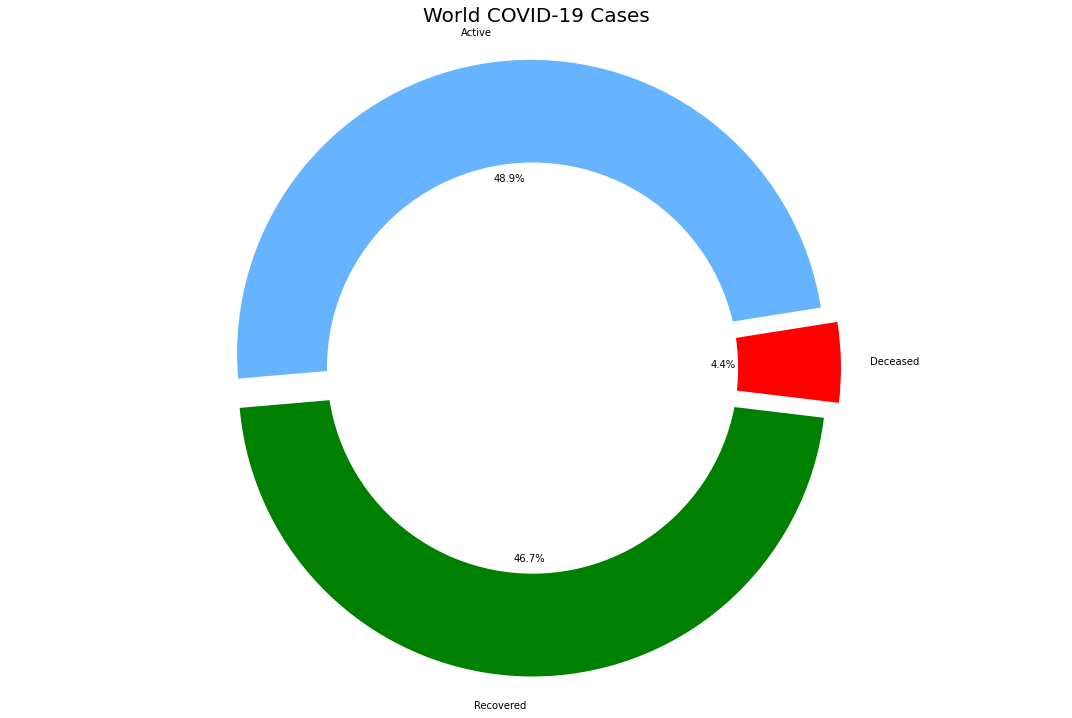

In [ ]:
world_confirmed = confirmed_df[confirmed_df.columns[-1:]].sum()
world_recovered = recovered_df[recovered_df.columns[-1:]].sum()
world_deaths = deaths_df[deaths_df.columns[-1:]].sum()
world_active = world_confirmed - (world_recovered - world_deaths)
 
labels = ['Active','Recovered','Deceased']
sizes = [world_active,world_recovered,world_deaths]
color= ['#66b3ff','green','red']
explode = []
 
for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode,colors = color)
centre_circle = plt.Circle((0,0),0.70,fc='white')
 
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('World COVID-19 Cases',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

Active, Recovered, Deaths in Hotspot Countries and India as of July 1

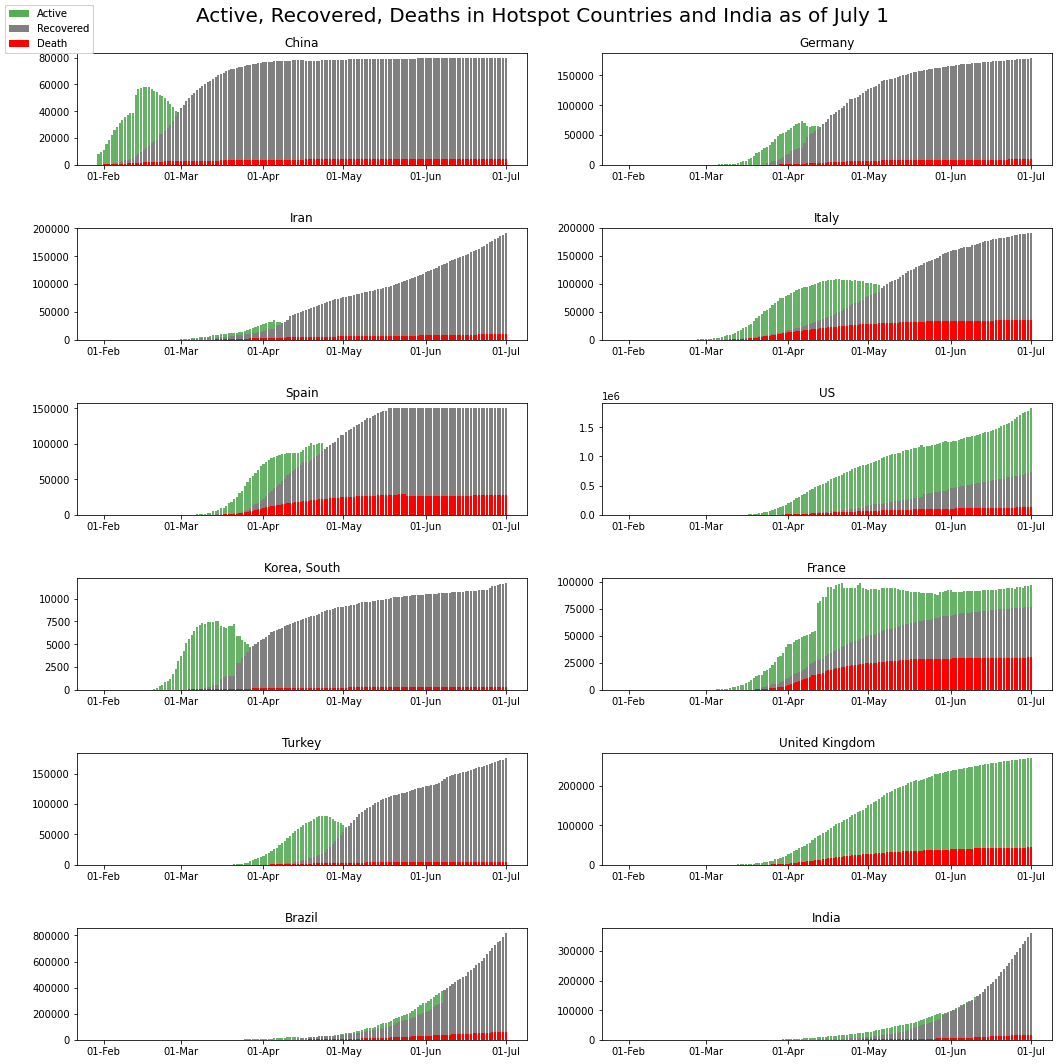

In [ ]:
hotspots = ['China','Germany','Iran','Italy','Spain','US','Korea, South','France','Turkey','United Kingdom', 'Brazil','India']
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]
 
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()
 
global_confirmed = {}
global_deaths = {}
global_recovered = {}
global_active= {}
 
for country in hotspots:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed[country] = k.values.tolist()[0]
 
    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths[country] = k.values.tolist()[0]
 
    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_recovered[country] = k.values.tolist()[0]
    
for country in hotspots:
    k = list(map(int.__sub__, global_confirmed[country], global_deaths[country]))
    global_active[country] = list(map(int.__sub__, k, global_recovered[country]))
    
fig = plt.figure(figsize= (15,15))
plt.suptitle('Active, Recovered, Deaths in Hotspot Countries and India as of July 1',fontsize = 20,y=1.0)
#plt.legend()
k=0
for i in range(1,13):
    ax = fig.add_subplot(6,2,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(dates_india,global_active[hotspots[k]],color = 'green',alpha = 0.6,label = 'Active');
    ax.bar(dates_india,global_recovered[hotspots[k]],color='grey',label = 'Recovered');
    ax.bar(dates_india,global_deaths[hotspots[k]],color='red',label = 'Death');   
    plt.title(hotspots[k])
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
 
plt.tight_layout(pad=3.0)

 Death rate per million in Countries

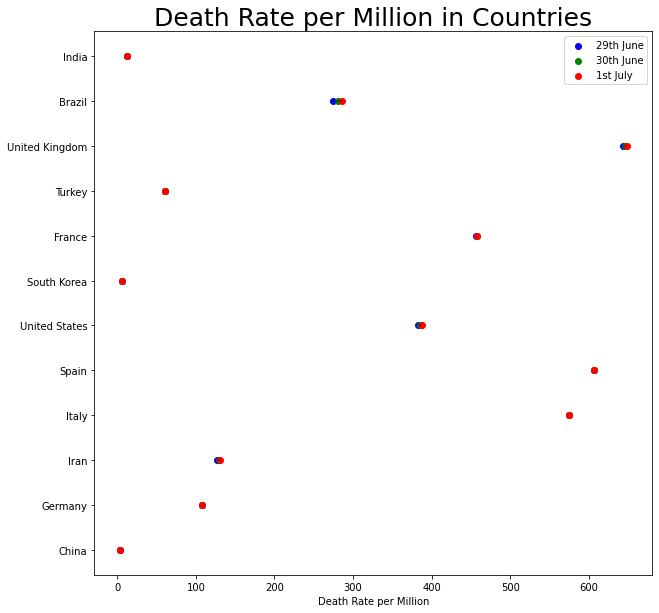

In [ ]:
hotspots = ['China','Germany','Iran','Italy','Spain','United States','South Korea','France','Turkey','United Kingdom','Brazil','India']
country_death_rate = pd.DataFrame(columns = ['country','day1','day2','day3'])
world_population['Population (2020)'] = world_population['Population (2020)']/1000000
 
d1=[]
d2 =[]
d3 = []
for country in hotspots:
    p = float(world_population[world_population['Country (or dependency)'] == country ]['Population (2020)'])
    if country == 'United States':
        k = global_deaths['US'][-3:]
    elif country == 'South Korea':
        k = global_deaths['Korea, South'][-3:]
    else:
        k = global_deaths[country][-3:]
    d1.append(round(k[0]/p,2))
    d2.append(round(k[1]/p,2))
    d3.append(round(k[2]/p,2))
 
country_death_rate['country'] = hotspots
country_death_rate['day1'] = d1
country_death_rate['day2'] = d2
country_death_rate['day3'] = d3    
 
plt.figure(figsize= (10,10))
plt.hlines(y=country_death_rate['country'], xmin=country_death_rate['day1'], xmax=country_death_rate['day3'], color='black', alpha=0.4);
plt.scatter(country_death_rate['day1'], country_death_rate['country'], color='blue', label='29th June');
plt.scatter(country_death_rate['day2'], country_death_rate['country'], color='green', label='30th June');
plt.scatter(country_death_rate['day3'], country_death_rate['country'], color='red', label='1st July');
plt.legend();
plt.title("Death Rate per Million in Countries",fontsize=25);
plt.xlabel('Death Rate per Million');


#India Update

 Age Group Analysis

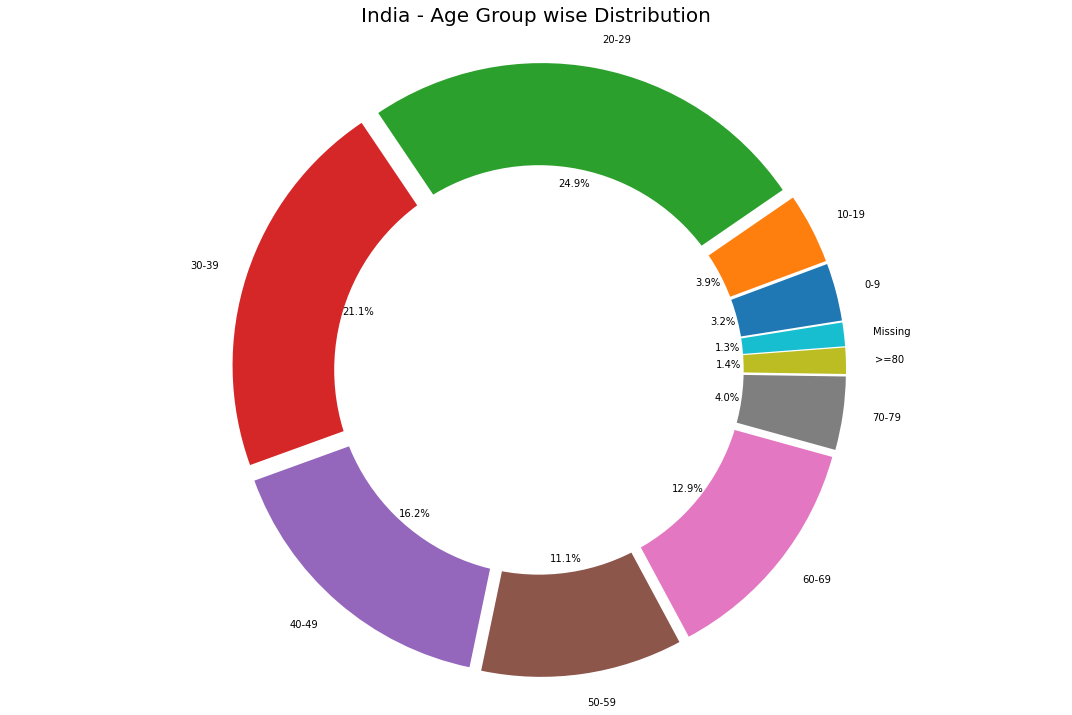

In [ ]:
labels = list(age_details['AgeGroup'])
sizes = list(age_details['TotalCases'])
 
explode = []
 
for i in labels:
    explode.append(0.05)
    
plt.figure(figsize= (15,10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=9, explode =explode)
centre_circle = plt.Circle((0,0),0.70,fc='white')
 
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('India - Age Group wise Distribution',fontsize = 20)
plt.axis('equal')  
plt.tight_layout()

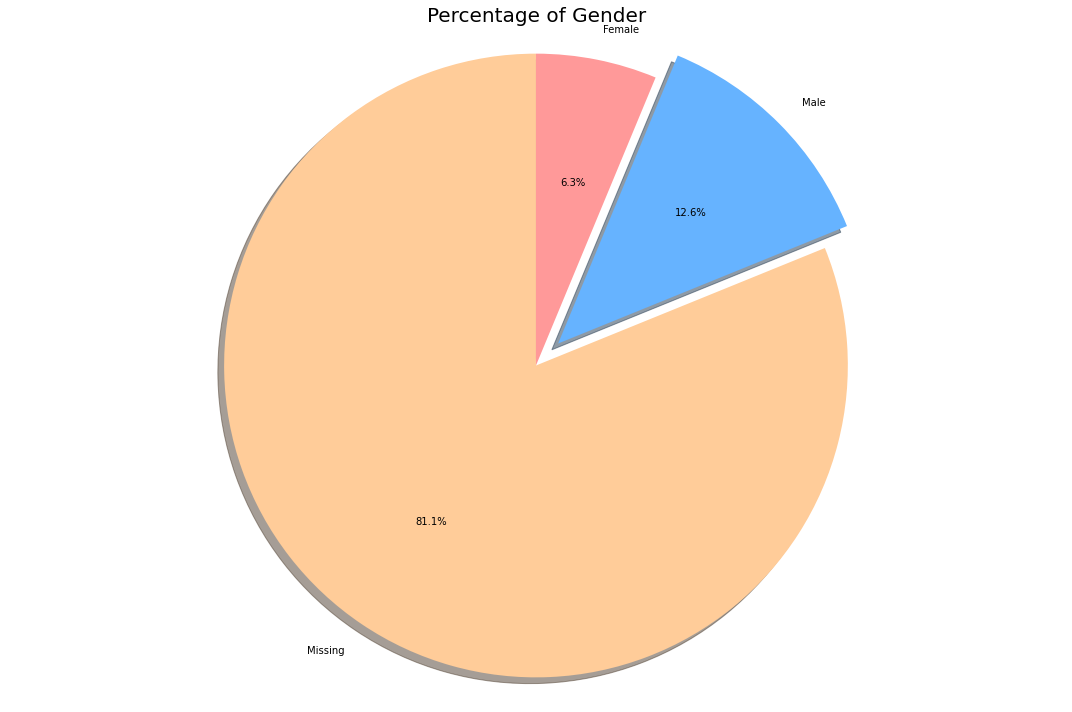

In [ ]:
labels = ['Missing', 'Male', 'Female']
sizes = []
sizes.append(individual_details['gender'].isnull().sum())
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])
 
explode = (0, 0.1, 0)
colors = ['#ffcc99','#66b3ff','#ff9999']
 
plt.figure(figsize= (15,10))
plt.title('Percentage of Gender',fontsize = 20)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=90)
plt.axis('equal')
plt.tight_layout()

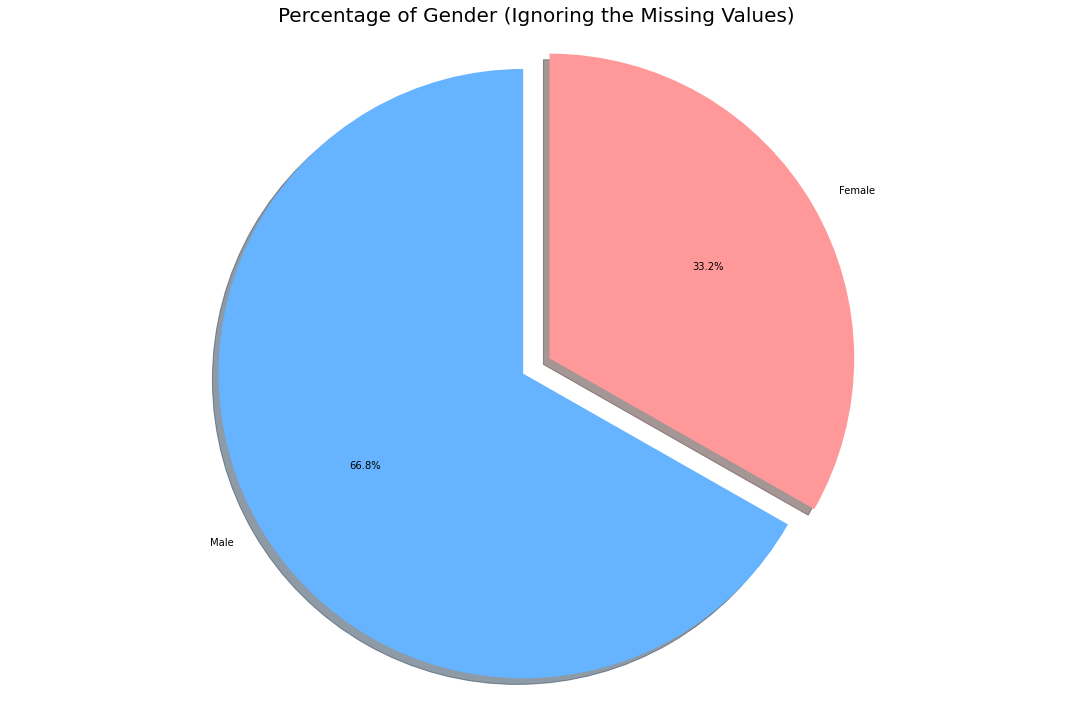

In [ ]:
labels = ['Male', 'Female']
sizes = []
sizes.append(list(individual_details['gender'].value_counts())[0])
sizes.append(list(individual_details['gender'].value_counts())[1])
 
explode = (0.1, 0)
colors = ['#66b3ff','#ff9999']
 
plt.figure(figsize= (15,10))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
 
plt.title('Percentage of Gender (Ignoring the Missing Values)',fontsize = 20)
plt.axis('equal')
plt.tight_layout()

 The Spike in India

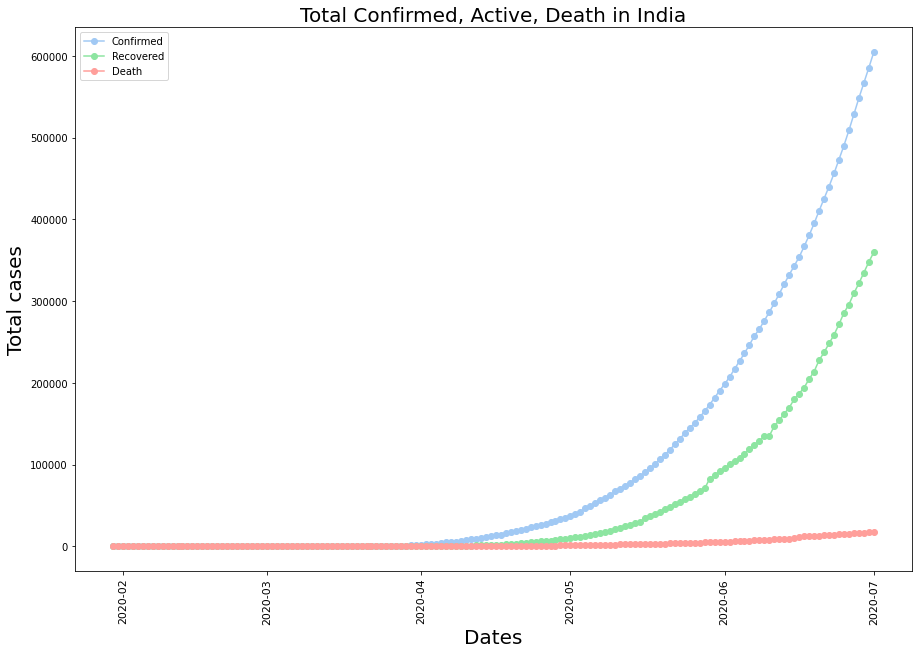

In [ ]:
dates = list(confirmed_df.columns[4:])
dates = list(pd.to_datetime(dates))
dates_india = dates[8:]
 
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()
 
k = df1[df1['Country/Region']=='India'].loc[:,'1/30/20':]
india_confirmed = k.values.tolist()[0] 
 
k = df2[df2['Country/Region']=='India'].loc[:,'1/30/20':]
india_deaths = k.values.tolist()[0] 
 
k = df3[df3['Country/Region']=='India'].loc[:,'1/30/20':]
india_recovered = k.values.tolist()[0] 
 
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Total Confirmed, Active, Death in India" , fontsize = 20)
 
ax1 = plt.plot_date(y= india_confirmed,x= dates_india,label = 'Confirmed',linestyle ='-',color = 'b')
ax2 = plt.plot_date(y= india_recovered,x= dates_india,label = 'Recovered',linestyle ='-',color = 'g')
ax3 = plt.plot_date(y= india_deaths,x= dates_india,label = 'Death',linestyle ='-',color = 'r')
plt.legend();

Comparison with other Countries

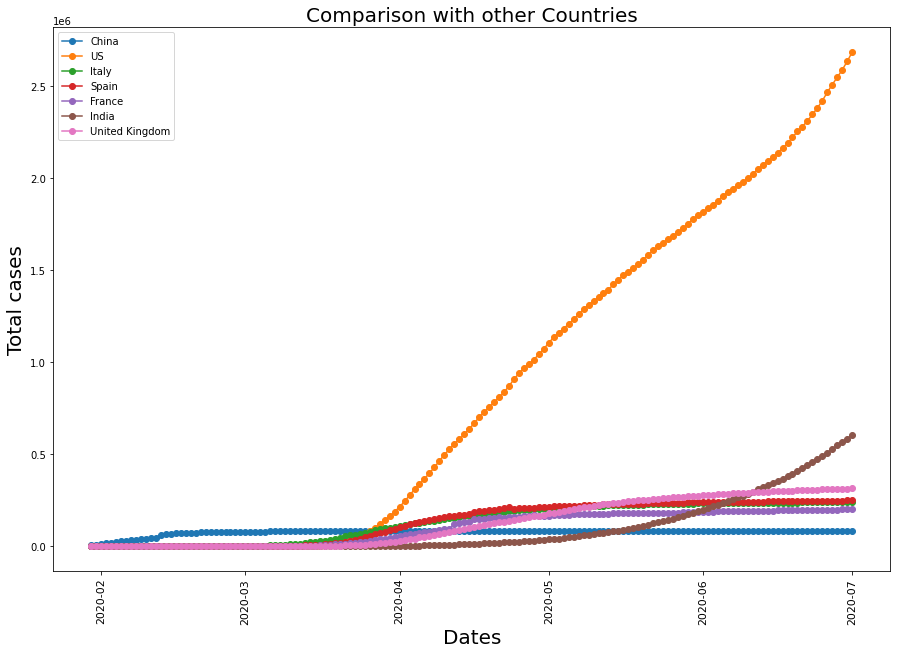

In [ ]:
countries = ['China','US', 'Italy', 'Spain', 'France','India','United Kingdom']
 
global_confirmed = []
global_recovered = []
global_deaths = []
global_active = []
 
for country in countries:
    k =df1[df1['Country/Region'] == country].loc[:,'1/30/20':]
    global_confirmed.append(k.values.tolist()[0]) 
 
    k =df2[df2['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0]) 
 
    k =df3[df3['Country/Region'] == country].loc[:,'1/30/20':]
    global_deaths.append(k.values.tolist()[0])  
 
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Comparison with other Countries" , fontsize = 20)
 
for i in range(len(countries)):
    plt.plot_date(y= global_confirmed[i],x= dates_india,label = countries[i],linestyle ='-')
plt.legend();

 State-wise Insight

In [ ]:
 state_cases = india_covid_19.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
 
#state_cases = state_cases.astype({'Deaths': 'int'})
state_cases['Active'] = state_cases['Confirmed'] - (state_cases['Deaths']+state_cases['Cured'])
state_cases["Death Rate (per 100)"] = np.round(100*state_cases["Deaths"]/state_cases["Confirmed"],2)
state_cases["Cure Rate (per 100)"] = np.round(100*state_cases["Cured"]/state_cases["Confirmed"],2)
state_cases.sort_values('Confirmed', ascending= False).fillna(0).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Blues',subset=["Deaths"])\
                        .background_gradient(cmap='Blues',subset=["Cured"])\
                        .background_gradient(cmap='Blues',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Death Rate (per 100)"])\
                        .background_gradient(cmap='Blues',subset=["Cure Rate (per 100)"])

,State/UnionTerritory,Confirmed,Deaths,Cured,Active,Death Rate (per 100),Cure Rate (per 100)
22,Maharashtra,174761,7855,90911,75995,4.490000,52.020000
32,Tamil Nadu,90167,1201,50074,38892,1.330000,55.530000
11,Delhi,87360,2742,58348,26270,3.140000,66.790000
13,Gujarat,32557,1846,23662,7049,5.670000,72.680000
37,Uttar Pradesh,23492,697,16084,6711,2.970000,68.470000
39,West Bengal,18559,668,12130,5761,3.600000,65.360000
30,Rajasthan,18014,413,14220,3381,2.290000,78.940000
33,Telangana,16339,260,7294,8785,1.590000,44.640000
18,Karnataka,15242,246,7918,7078,1.610000,51.950000
1,Andhra Pradesh,14595,187,6511,7897,1.280000,44.610000


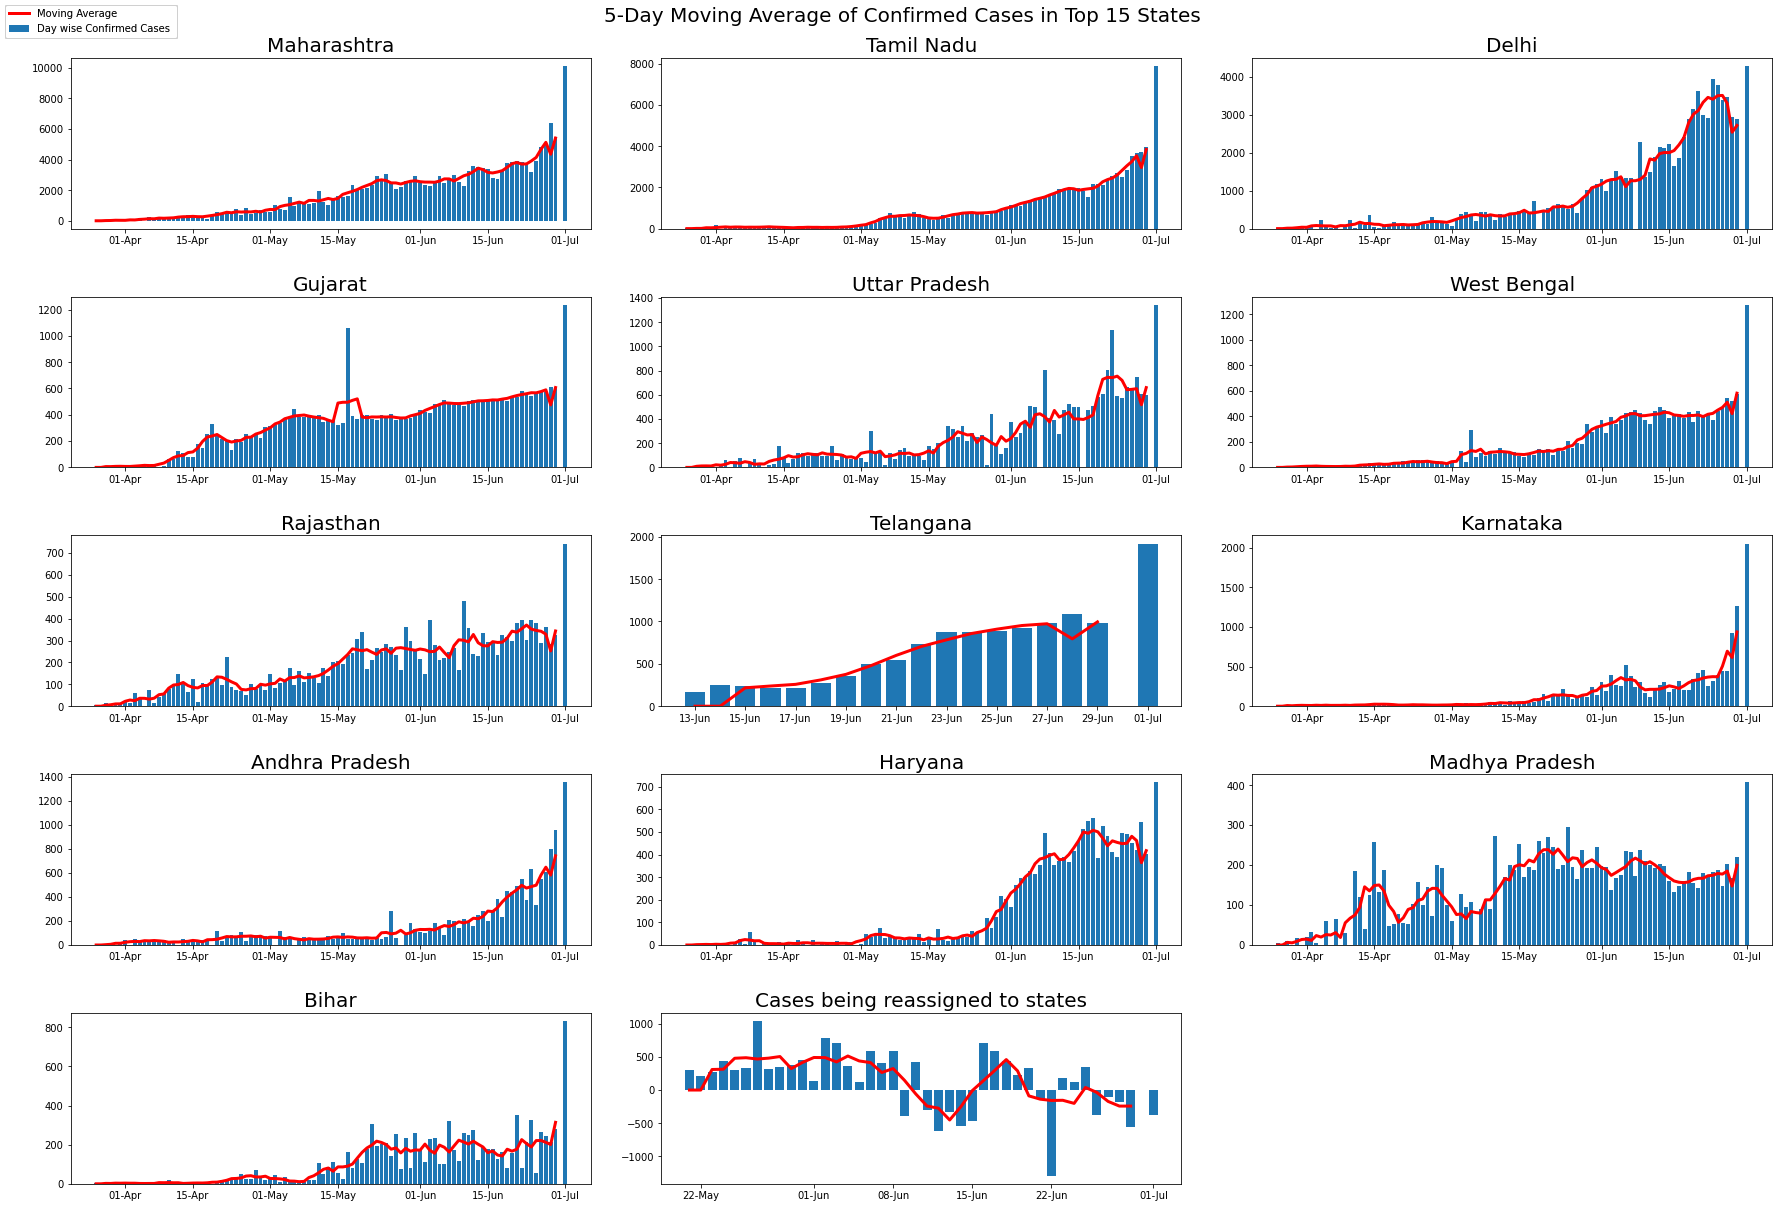

In [ ]:
all_state = list(india_covid_19['State/UnionTerritory'].unique())
all_state.remove('Unassigned')
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])
 
states_confirmed = {}
states_deaths = {}
states_recovered = {}
states_active = {}
states_dates = {}
 
for state in states:
    df = latest[latest['State/UnionTerritory'] == state].reset_index()
    k = []
    l = []
    m = []
    n = []
    for i in range(1,len(df)):
        k.append(df['Confirmed'][i]-df['Confirmed'][i-1])
        l.append(df['Deaths'][i]-df['Deaths'][i-1])
        m.append(df['Cured'][i]-df['Cured'][i-1])
        n.append(df['Active'][i]-df['Active'][i-1])
    states_confirmed[state] = k
    states_deaths[state] = l
    states_recovered[state] = m
    states_active[state] = n
    date = list(df['Date'])
    states_dates[state] = date[1:]
    
def calcaverage(values ,N):    
    cumsum, moving_aves = [0], [0,0]
    for i, x in enumerate(values, 1):
        cumsum.append(cumsum[i-1] + x)
        if i>=N:
            moving_ave = (cumsum[i] - cumsum[i-N])/N
            moving_aves.append(moving_ave)
    return moving_aves
 
fig = plt.figure(figsize= (25,17))
plt.suptitle('5-Day Moving Average of Confirmed Cases in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    moving_aves = calcaverage(states_confirmed[states[k]],5)
    ax.plot(states_dates[states[k]][:-2],moving_aves,color='red',label = 'Moving Average',linewidth =3)  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

Growth rate in top 15 states

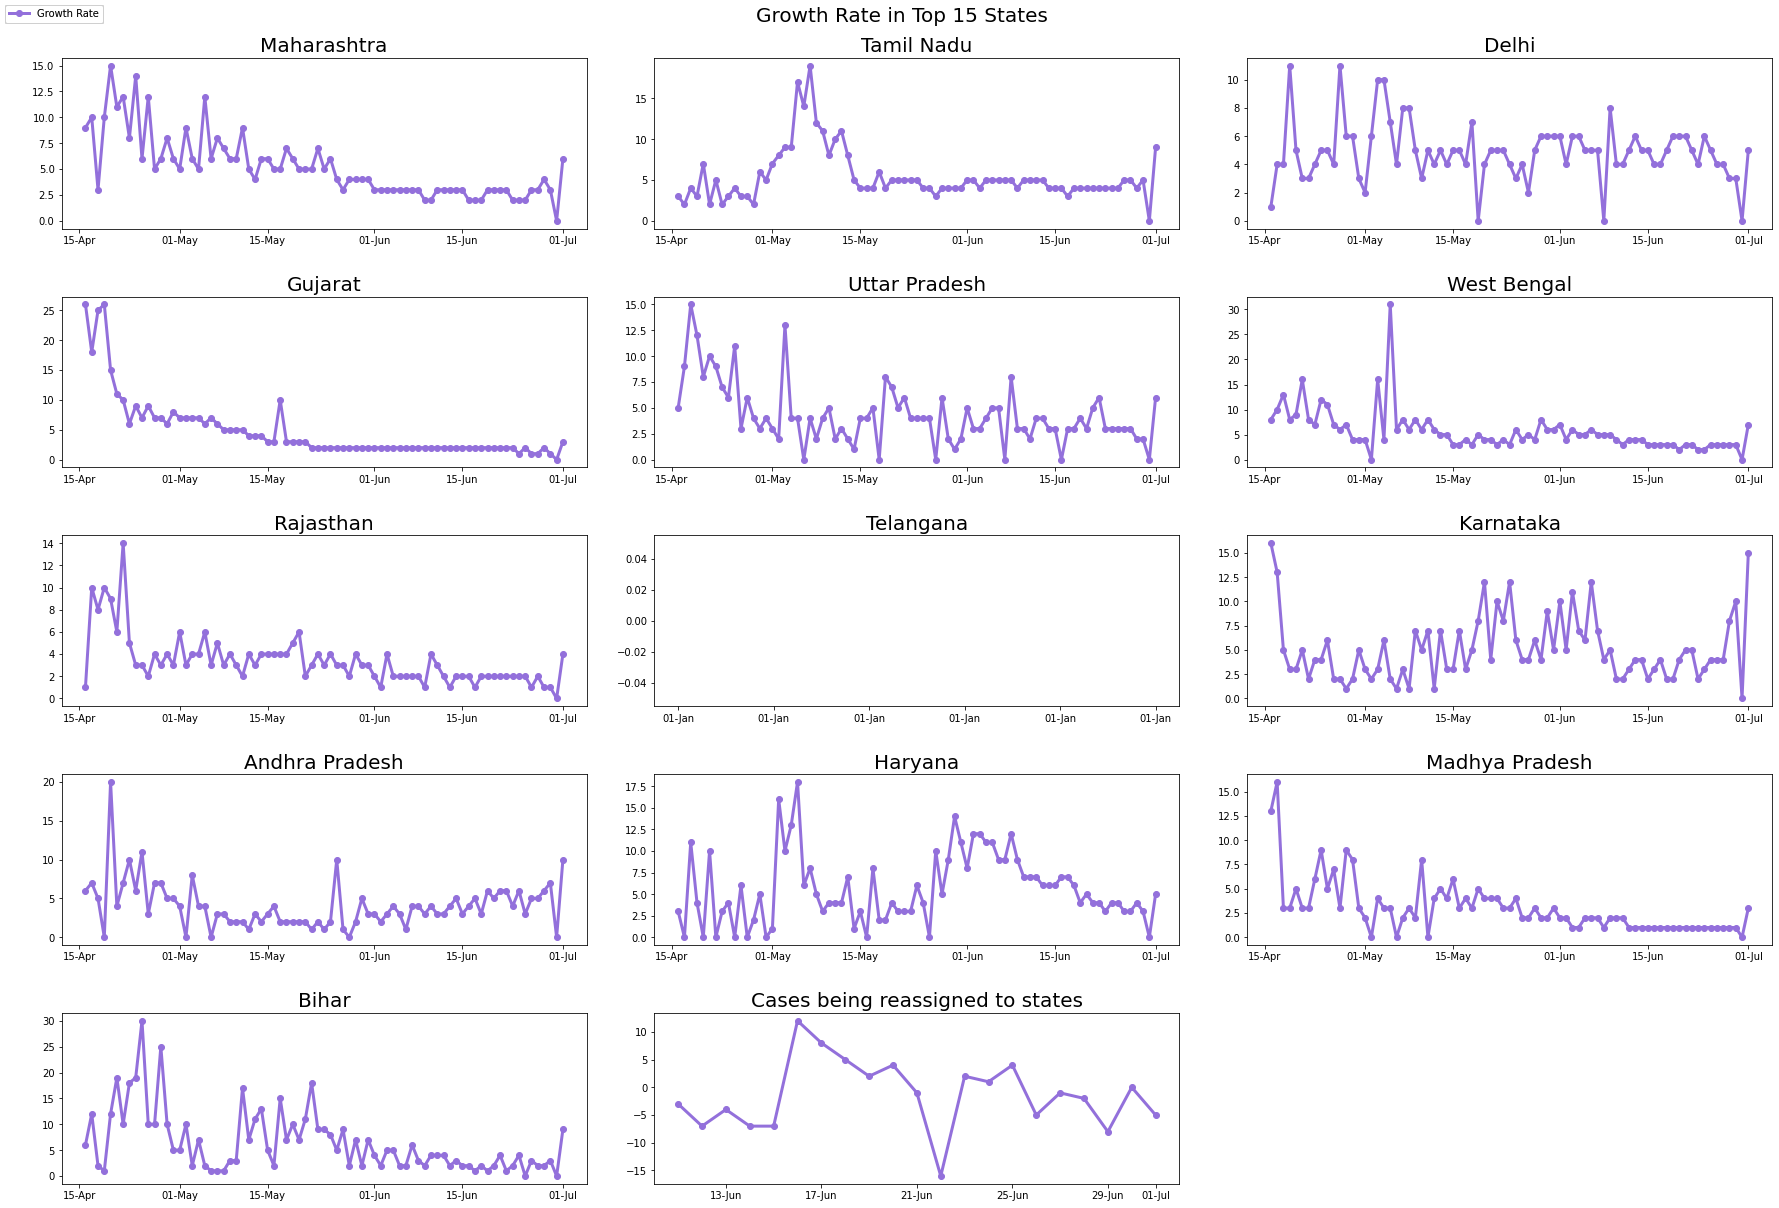

In [ ]:
 def calc_growthRate(values):
    k = []
    for i in range(1,len(values)):
        summ = 0
        for j in range(i):
            summ = summ + values[j]
        rate = (values[i]/summ)*100
        k.append(int(rate))
    return k
 
fig = plt.figure(figsize= (25,17))
plt.suptitle('Growth Rate in Top 15 States',fontsize = 20,y=1.0)
k=0
for i in range(1,15):
    ax = fig.add_subplot(5,3,i)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    #ax.bar(states_dates[states[k]],states_confirmed[states[k]],label = 'Day wise Confirmed Cases ') 
    growth_rate = calc_growthRate(states_confirmed[states[k]])
    ax.plot_date(states_dates[states[k]][21:],growth_rate[20:],color = '#9370db',label = 'Growth Rate',linewidth =3,linestyle='-')  
    plt.title(states[k],fontsize = 20)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper left')
    k=k+1
plt.tight_layout(pad=3.0)

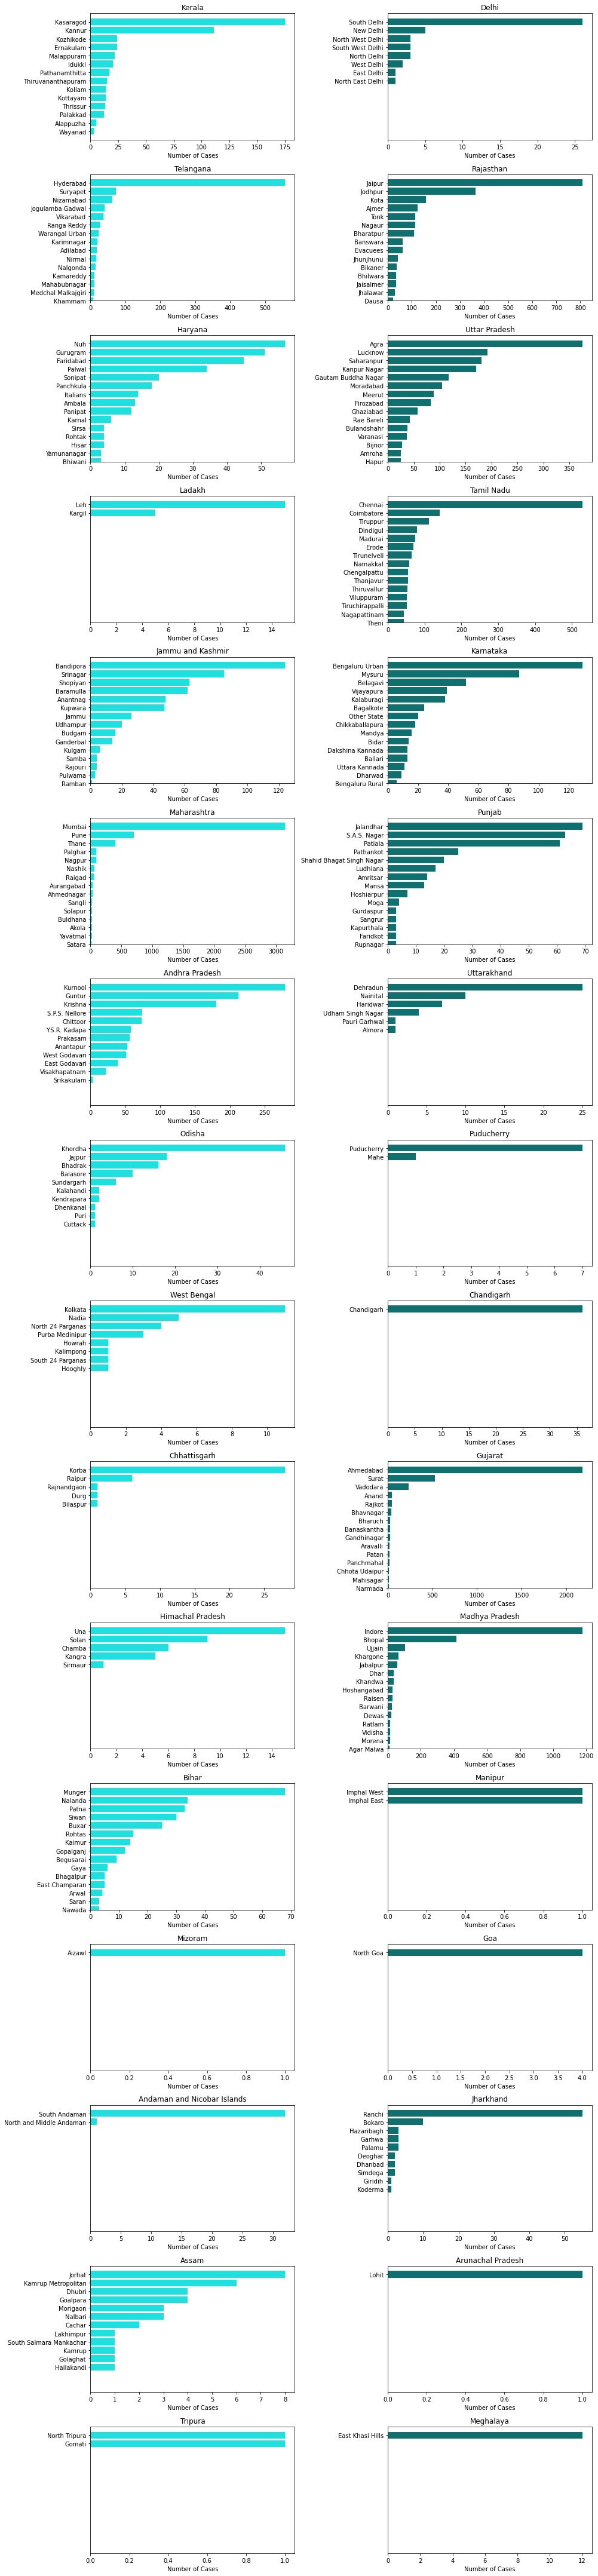

In [ ]:
colors_list = ['cyan','teal']
states = individual_details['detected_state'].unique()
if len(states)%2==0:
    n_rows = int(len(states)/2)
else:
    n_rows = int((len(states)+1)/2)    
plt.figure(figsize=(14,60))
 
for idx,state in enumerate(states):    
    plt.subplot(n_rows,2,idx+1)
    y_order = individual_details[individual_details['detected_state']==state]['detected_district'].value_counts().index
    try:
        g = sns.countplot(data=individual_details[individual_details['detected_state']==state],y='detected_district',orient='v',color=colors_list[idx%2],order=y_order)
        plt.xlabel('Number of Cases')
        plt.ylabel('')
        plt.title(state)
        plt.ylim(14,-1)
    except:
        pass
plt.tight_layout()
plt.show()

Death rate per million in hotspot stated

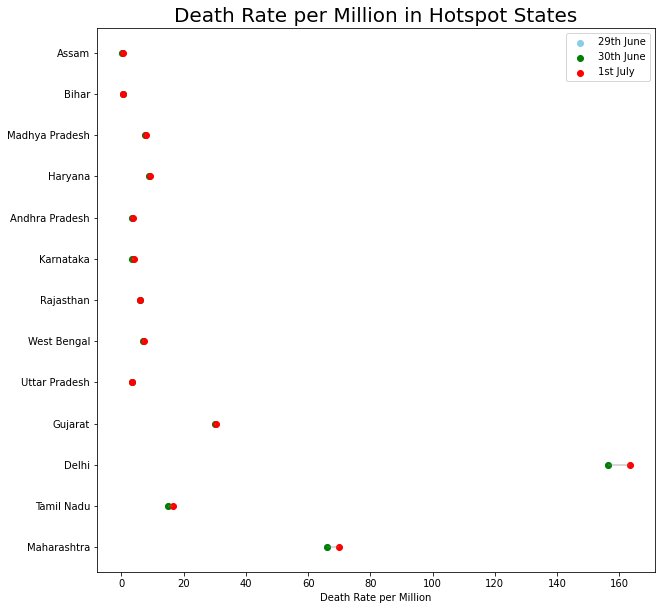

In [ ]:
population['in_million'] = population['Population']/1000000
state_death_rate = pd.DataFrame(columns = ['state','day1','day2','day3'])
latest = india_covid_19[india_covid_19['Date'] > '24-03-20']
state_cases = latest.groupby('State/UnionTerritory')['Confirmed','Deaths','Cured'].max().reset_index()
latest['Active'] = latest['Confirmed'] - (latest['Deaths']- latest['Cured'])
state_cases = state_cases.sort_values('Confirmed', ascending= False).fillna(0)
states =list(state_cases['State/UnionTerritory'][0:15])
 
s = []
d1 = []
d2 = []
d3 = []
 
for state in states:
    k = list(india_covid_19[india_covid_19['State/UnionTerritory'] == state]['Deaths'].tail(3))
    p = list(population[population['State / Union Territory']== state]['in_million'])
    for P in p:
        d1.append(round(k[0]/P,2))
        d2.append(round(k[1]/P,2))
        d3.append(round(k[2]/P,2))
        s.append(state)
    
state_death_rate['state'] = s
state_death_rate['day1'] = d1
state_death_rate['day2'] = d2
state_death_rate['day3'] = d3
 
plt.figure(figsize= (10,10))
plt.hlines(y=state_death_rate['state'], xmin=state_death_rate['day1'], xmax=state_death_rate['day3'], color='grey', alpha=0.4);
plt.scatter(state_death_rate['day1'], state_death_rate['state'], color='skyblue', label='29th June');
plt.scatter(state_death_rate['day2'], state_death_rate['state'], color='green', label='30th June');
plt.scatter(state_death_rate['day3'], state_death_rate['state'], color='red', label='1st July');
plt.legend();
plt.title("Death Rate per Million in Hotspot States",fontsize=20);
plt.xlabel('Death Rate per Million');

Top 10 states in each health facility

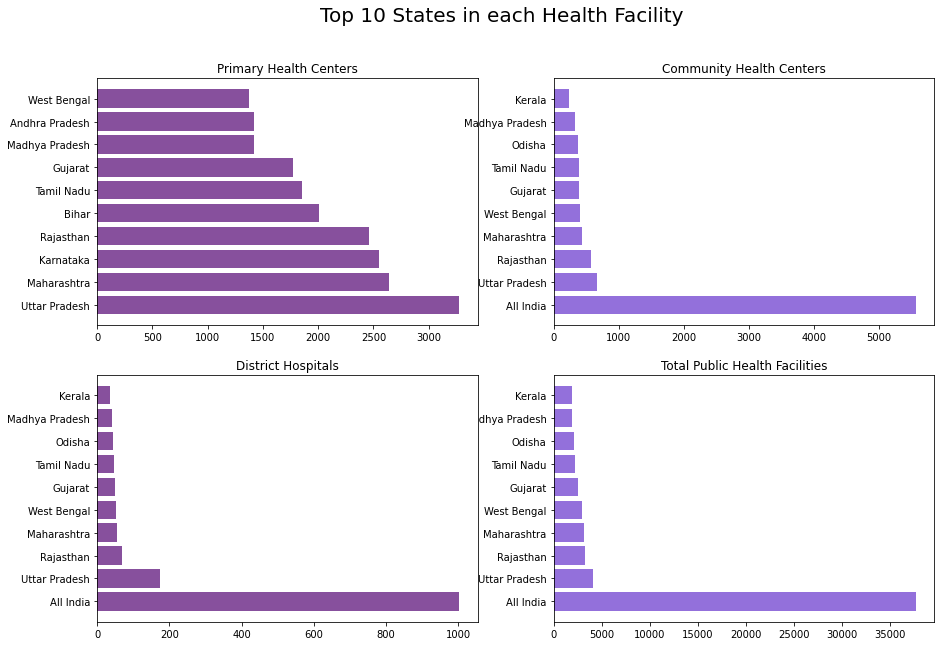

In [ ]:
hospital_beds.fillna(0,inplace=True)
cols_object = list(hospital_beds.columns[2:8])
 
for cols in cols_object:
    hospital_beds[cols] = hospital_beds[cols].astype(int,errors='ignore')
top_10_primary = hospital_beds.nlargest(10,'NumPrimaryHealthCenters_HMIS')
top_10_community = hospital_beds.nlargest(10,'NumCommunityHealthCenters_HMIS')
top_10_district_hospitals = hospital_beds.nlargest(10,'NumDistrictHospitals_HMIS')
top_10_public_facility = hospital_beds.nlargest(10,'TotalPublicHealthFacilities_HMIS')
top_10_public_beds = hospital_beds.nlargest(10,'NumPublicBeds_HMIS')
 
plt.figure(figsize=(15,10))
plt.suptitle('Top 10 States in each Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Primary Health Centers')
plt.barh(top_10_primary['State/UT'],top_10_primary['NumPrimaryHealthCenters_HMIS'],color ='#87509d');
 
plt.subplot(222)
plt.title('Community Health Centers')
plt.barh(top_10_community['State/UT'],top_10_community['NumCommunityHealthCenters_HMIS'],color = '#9370db');
 
plt.subplot(224)
plt.title('Total Public Health Facilities')
plt.barh(top_10_community['State/UT'],top_10_public_facility['TotalPublicHealthFacilities_HMIS'],color='#9370db');
 
plt.subplot(223)
plt.title('District Hospitals')
plt.barh(top_10_community['State/UT'],top_10_district_hospitals['NumDistrictHospitals_HMIS'],color = '#87509d');

Urban and Rural health facility

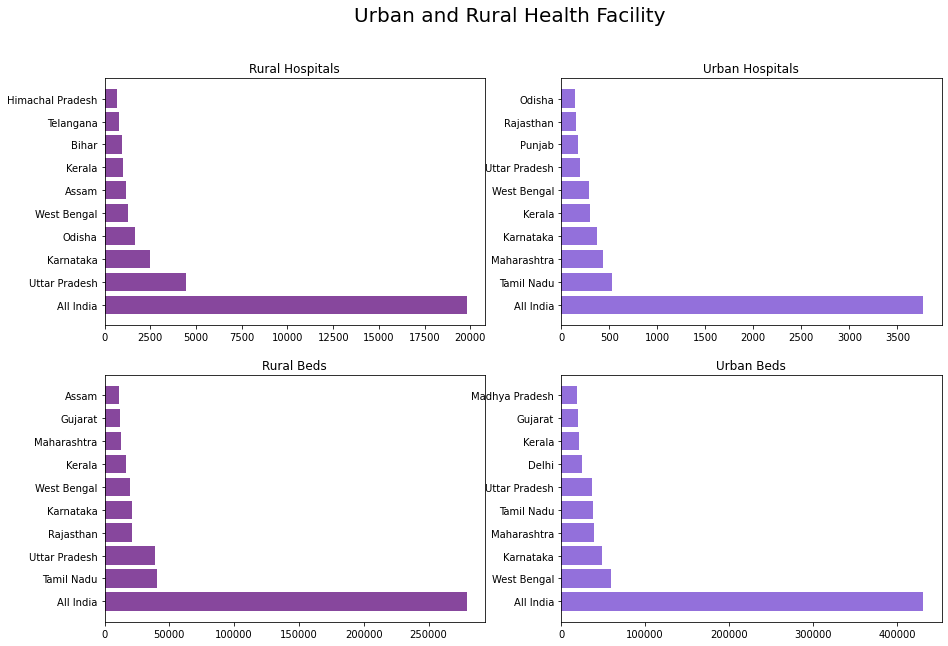

In [ ]:
top_rural_hos = hospital_beds.nlargest(10,'NumRuralHospitals_NHP18')
top_rural_beds = hospital_beds.nlargest(10,'NumRuralBeds_NHP18')
top_urban_hos = hospital_beds.nlargest(10,'NumUrbanHospitals_NHP18')
top_urban_beds = hospital_beds.nlargest(10,'NumUrbanBeds_NHP18')
 
plt.figure(figsize=(15,10))
plt.suptitle('Urban and Rural Health Facility',fontsize=20)
plt.subplot(221)
plt.title('Rural Hospitals')
plt.barh(top_rural_hos['State/UT'],top_rural_hos['NumRuralHospitals_NHP18'],color = '#87479d');
 
plt.subplot(222)
plt.title('Urban Hospitals')
plt.barh(top_urban_hos['State/UT'],top_urban_hos['NumUrbanHospitals_NHP18'],color = '#9370db');
 
plt.subplot(223)
plt.title('Rural Beds')
plt.barh(top_rural_beds['State/UT'],top_rural_beds['NumRuralBeds_NHP18'],color = '#87479d');
 
plt.subplot(224)
plt.title('Urban Beds')
plt.barh(top_urban_beds['State/UT'],top_urban_beds['NumUrbanBeds_NHP18'],color = '#9370db');

ICMR Testing Centers each States

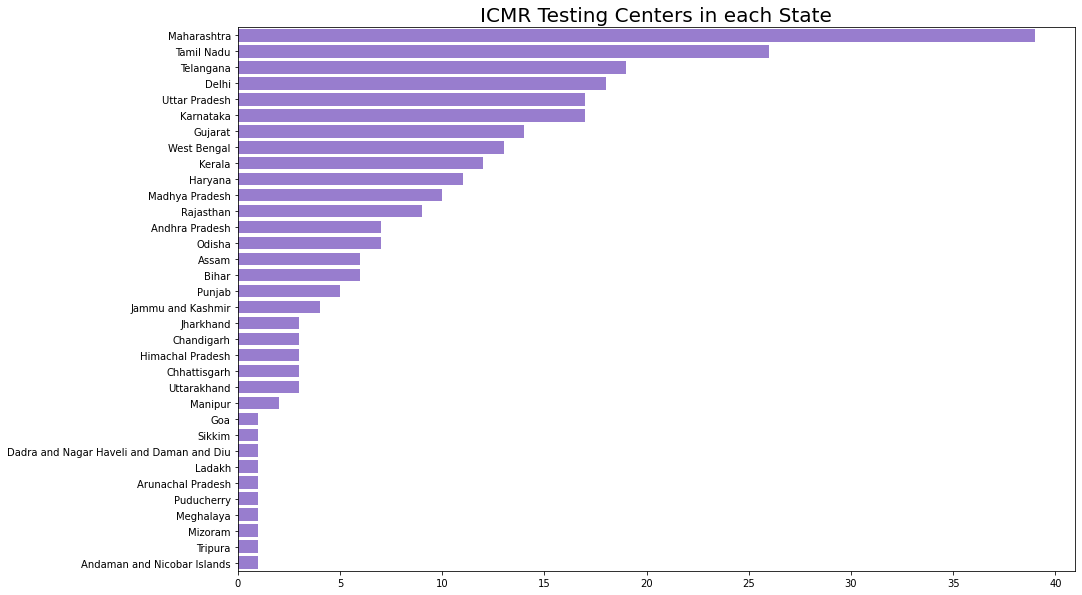

In [ ]:
values = list(ICMR_labs['state'].value_counts())
names = list(ICMR_labs['state'].value_counts().index)
 
plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
plt.title('ICMR Testing Centers in each State', fontsize = 20)
sns.barplot(x= values, y= names,color = '#9370db');

Testing Statewise Insight

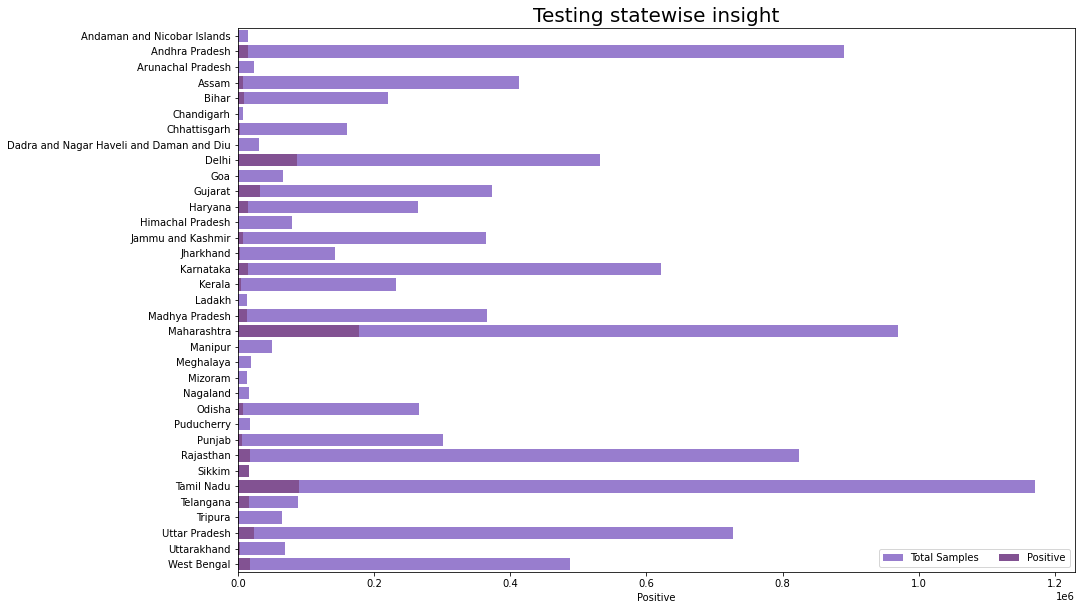

In [ ]:
 
state_test = pd.pivot_table(state_testing,values=['TotalSamples','Negative','Positive'], index='State',aggfunc='max')
state_names = list(state_test.index)
state_test['State'] = state_names
 
plt.figure(figsize=(15,10))
sns.set_color_codes("pastel")
sns.barplot(x="TotalSamples", y= state_names, data=state_test,label="Total Samples", color = '#9370db')
sns.barplot(x='Positive', y=state_names, data=state_test,label='Positive', color='#87479d')
plt.title('Testing statewise insight',fontsize = 20)
plt.legend(ncol=2, loc="lower right", frameon=True);

##Predictions  :

Growth Factor

In [ ]:
df1 = confirmed_df.groupby('Country/Region').sum().reset_index()
df2 = deaths_df.groupby('Country/Region').sum().reset_index()
df3 = recovered_df.groupby('Country/Region').sum().reset_index()
 
k =df1[df1['Country/Region']=='India'].loc[:,'2/4/20':]
india_confirmed = k.values.tolist()[0] 
 
growth_diff = []
 
for i in range(1,len(india_confirmed)):
    growth_diff.append(india_confirmed[i] / india_confirmed[i-1])
 
growth_factor = sum(growth_diff)/len(growth_diff)
print('Average growth factor',growth_factor)

Average growth factor 1.107883228167614


Predicted Values for next 15 days

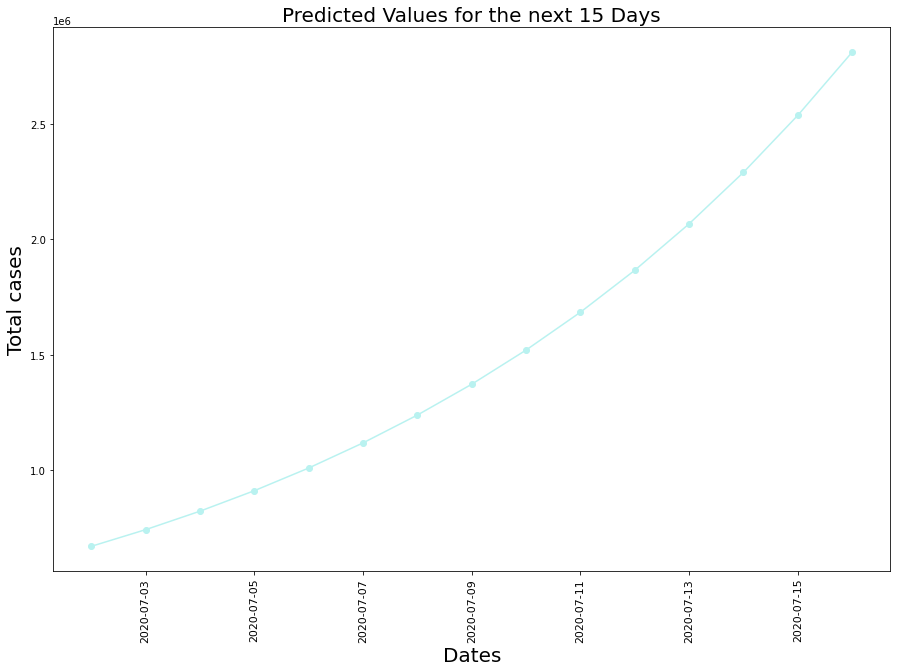

In [ ]:
prediction_dates = []
 
start_date = dates_india[len(dates_india) - 1]
for i in range(15):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
previous_day_cases = global_confirmed[5][len(dates_india) - 1]
predicted_cases = []
 
for i in range(15):
    predicted_value = previous_day_cases *  growth_factor
    predicted_cases.append(predicted_value)
    previous_day_cases = predicted_value
 
plt.figure(figsize= (15,10))
plt.xticks(rotation = 90 ,fontsize = 11)
plt.yticks(fontsize = 10)
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
ax1 = plt.plot_date(y= predicted_cases,x= prediction_dates,linestyle ='-',color = 'c')

In [ ]:
 
train_file = drive.CreateFile({'id': '1aabBuYYesAQip-6RIFjxHt3CGYinsQNZ'})
train_file.GetContentFile('train_covid19.csv')
train=pd.read_csv('train_covid19.csv')
test_file = drive.CreateFile({'id': '1aZRXfcwWGEo-xWkKPDhOneAp7YfV-st2'})
test_file.GetContentFile('test_covid19.csv')
test = pd.read_csv('test_covid19.csv')
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1aabBuYYesAQip-6RIFjxHt3CGYinsQNZ?alt=json
INFO:googleapiclient.discovery:URL being requested: GET https://www.googleapis.com/drive/v2/files/1aZRXfcwWGEo-xWkKPDhOneAp7YfV-st2?alt=json


Prediction using Prophet Model

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


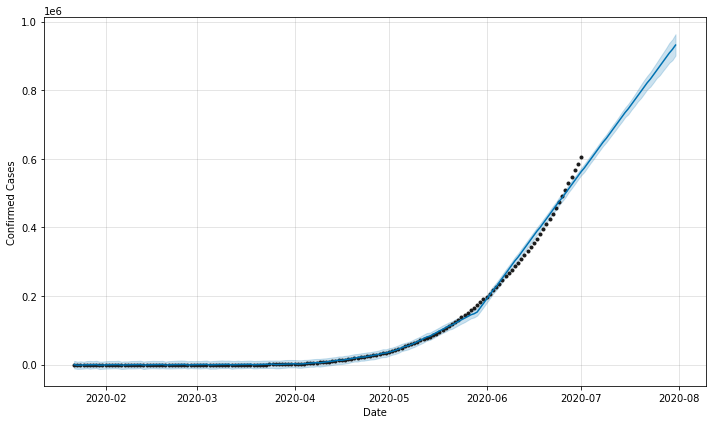

In [ ]:
k = df1[df1['Country/Region']=='India'].loc[:,'1/22/20':]
india_confirmed = k.values.tolist()[0] 
data = pd.DataFrame(columns = ['ds','y'])
data['ds'] = dates
data['y'] = india_confirmed
 
prop=Prophet()
prop.fit(data)
future=prop.make_future_dataframe(periods=30)
prop_forecast=prop.predict(future)
forecast = prop_forecast[['ds','yhat']].tail(30)
 
fig = plot_plotly(prop, prop_forecast)
fig = prop.plot(prop_forecast,xlabel='Date',ylabel='Confirmed Cases')

Prediction using Arima

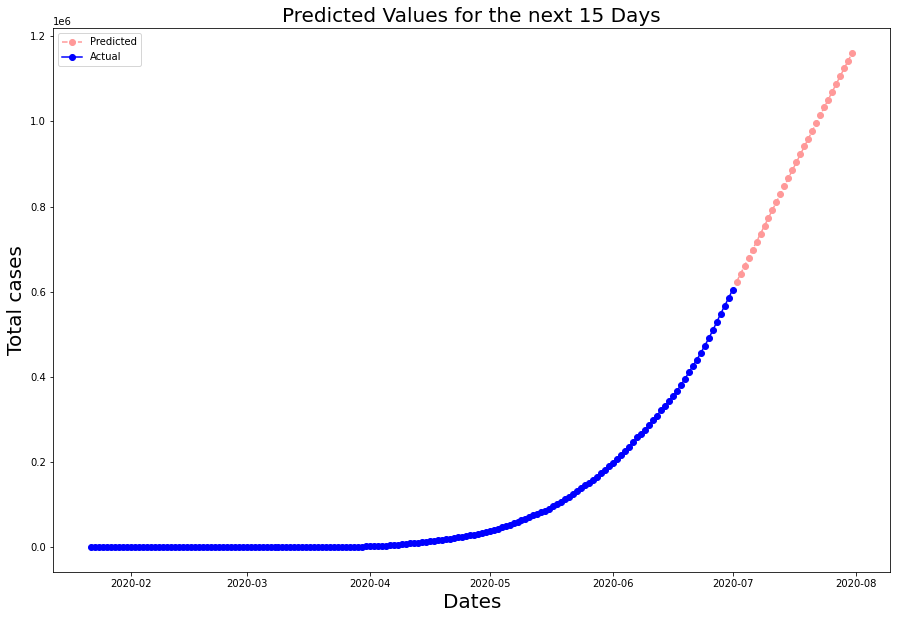

In [ ]:
 
arima = ARIMA(data['y'], order=(5, 1, 0))
arima = arima.fit(trend='c', full_output=True, disp=True)
forecast = arima.forecast(steps= 30)
pred = list(forecast[0])
 
start_date = data['ds'].max()
prediction_dates = []
for i in range(30):
    date = start_date + datetime.timedelta(days=1)
    prediction_dates.append(date)
    start_date = date
plt.figure(figsize= (15,10))
plt.xlabel("Dates",fontsize = 20)
plt.ylabel('Total cases',fontsize = 20)
plt.title("Predicted Values for the next 15 Days" , fontsize = 20)
 
plt.plot_date(y= pred,x= prediction_dates,linestyle ='dashed',color = '#ff9999',label = 'Predicted');
plt.plot_date(y=data['y'],x=data['ds'],linestyle = '-',color = 'blue',label = 'Actual');
plt.legend();

In [ ]:
 
 
train['day'] = train['Date'].dt.day
train['month'] = train['Date'].dt.month
train['dayofweek'] = train['Date'].dt.dayofweek
train['dayofyear'] = train['Date'].dt.dayofyear
train['quarter'] = train['Date'].dt.quarter
train['weekofyear'] = train['Date'].dt.weekofyear
test['day'] = test['Date'].dt.day
test['month'] = test['Date'].dt.month
test['dayofweek'] = test['Date'].dt.dayofweek
test['dayofyear'] = test['Date'].dt.dayofyear
test['quarter'] = test['Date'].dt.quarter
test['weekofyear'] = test['Date'].dt.weekofyear
countries = list(train['Country_Region'].unique())
india_code = countries.index('India')
train = train.drop(['Date','Id'],1)
test =  test.drop(['Date'],1)
 
train.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
train[['Province_State','Country_Region']] = oe.fit_transform(train.loc[:,['Province_State','Country_Region']])
 
test.Province_State.fillna('NaN', inplace=True)
oe = OrdinalEncoder()
test[['Province_State','Country_Region']] = oe.fit_transform(test.loc[:,['Province_State','Country_Region']])

In [ ]:
columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State', 'Country_Region','ConfirmedCases','Fatalities']
test_columns = ['day','month','dayofweek','dayofyear','quarter','weekofyear','Province_State','Country_Region']
train = train[columns]
x = train.drop(['Fatalities','ConfirmedCases'], 1)
y = train['ConfirmedCases']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)
test = test[test_columns]
test_india = test[test['Country_Region'] == india_code]

In [ ]:
models = []
mean_sqr_error = []
mean_abs_error = []
root_mean_sqr_error = []

LGBM Regressor

In [ ]:
lgbm = LGBMRegressor(n_estimators=1300)
lgbm.fit(x_train,y_train)
pred = lgbm.predict(x_test)
lgbm_forecast = lgbm.predict(test_india)
models.append('LGBM')
mean_sqr_error.append(round(mean_squared_error(pred, y_test),2))
mean_abs_error.append(round(mean_absolute_error(pred, y_test),2))
root_mean_sqr_error.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

 Random Forest Regressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(x_train,y_train)
pred = rf.predict(x_test)
rfr_forecast = rf.predict(test_india)
models.append('Random Forest')
mean_sqr_error.append(round(mean_squared_error(pred, y_test),2))
mean_abs_error.append(round(mean_absolute_error(pred, y_test),2))
root_mean_sqr_error.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

XGB Regressor

In [ ]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(x_train,y_train)
pred = xgb.predict(x_test)
xgb_forecast = xgb.predict(test_india)
models.append('XGBoost')
mean_sqr_error.append(round(mean_squared_error(pred, y_test),2))
mean_abs_error.append(round(mean_absolute_error(pred, y_test),2))
root_mean_sqr_error.append(round(np.sqrt(mean_squared_error(pred, y_test)),2))

[09:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
